## 1.1. Подготовка данных 


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize


%matplotlib inline

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(data, train_size=0.7, shuffle = True)

train_dataset = torch.Tensor(train)
val = torch.Tensor(val)

batch = 16
train_dataloader = data_utils.DataLoader(train_dataset, batch_size=batch, shuffle = True)
val_dataloader = data_utils.DataLoader(val, batch_size=batch, shuffle = True)

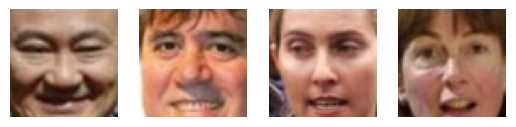

In [ ]:
def display(data, model = None, count=4):
  imgs = data[np.random.choice(len(data), count)]

  f, axarr = plt.subplots(1, count)
  for i in range(count):
    if model:
      img, _ = model(data[np.random.choice(len(data))].view(-1, 3, 64, 64))
      axarr[i].imshow(img.view(64,64,3).detach().numpy())
      axarr[i].axis('off')
    else:
      axarr[i].imshow(imgs[i].view(64,64,3))
      axarr[i].axis('off')

  plt.show()


display(val)

## 1.2. Архитектура модели 
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">




In [1]:
latent_dims = 512 

Реализуем autoencoder

In [ ]:
class encoder(nn.Module):
  def __init__(self, latent_dims):
    super().__init__()

    self.encoder = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=2),
          nn.BatchNorm2d(8),
          nn.PReLU(),
          nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=2),
          nn.BatchNorm2d(16),
          nn.PReLU(),
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=2),
          nn.BatchNorm2d(32),
          nn.PReLU(),
        )

    self.fc = nn.Sequential(
        nn.Linear(800, latent_dims),
        nn.PReLU()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = torch.flatten(x, start_dim=1)
    x = self.fc(x)
    return x

In [ ]:
class decoder(nn.Module):
  def __init__(self, latent_dims):
    super().__init__()

    self.decoder = nn.Sequential(
        nn.Linear(latent_dims, 32*8*8),
        nn.PReLU(),
        nn.Unflatten(1, (32,8,8)),
        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2),
        nn.BatchNorm2d(16),
        nn.PReLU(),
        nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2),
        nn.BatchNorm2d(8),
        nn.PReLU(),
        nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=2, stride=2, padding=3),
        nn.BatchNorm2d(3),
        nn.PReLU()
    )

  def forward(self, x):
    x = self.decoder(x)
    x = torch.sigmoid(x)
    return x.reshape((-1,3,64,64)), x

In [ ]:
from re import X
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        # Обратите внимание на формат, в котором функция fetch() возвращает data
        super().__init__()

        self.ENCODER = encoder(latent_dims)
        self.DECODER = decoder(latent_dims)

    def forward(self, x):
      x = self.ENCODER(x)
      x = self.DECODER(x)
      return x

In [ ]:
criterion = nn.MSELoss()

autoencoder = Autoencoder(latent_dims)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.001)

## 1.3 Обучение 

In [ ]:
from tqdm import tqdm

In [ ]:
def train(data, model, epochs, criterion, optimizer, val):
  loss_epochs = []
  for epoch in range(epochs):
    print(f"epoch_{epoch+1}")
    loss_epoch = []
    for batch in tqdm(data):
      optimizer.zero_grad()
      img, latent = model(batch.view(-1, 3, 64, 64))
      loss = criterion(img, batch.view(-1, 3, 64, 64))
      loss_epoch.append(loss.item())
      loss.backward()
      optimizer.step()
    print(f'loss_epoch_{epoch+1} = {np.mean(loss_epoch)}')
    loss_epochs.append(loss_epoch)
    display(val, model)
  return loss_epochs

epoch_1


100%|██████████| 575/575 [00:27<00:00, 21.07it/s]


loss_epoch_1 = 0.018235993418518615


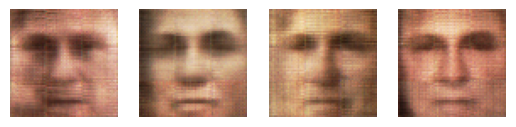

epoch_2


100%|██████████| 575/575 [00:26<00:00, 22.01it/s]


loss_epoch_2 = 0.006454983752868746


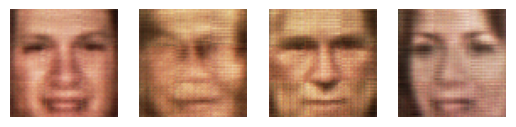

epoch_3


100%|██████████| 575/575 [00:25<00:00, 22.23it/s]


loss_epoch_3 = 0.004931689630384031


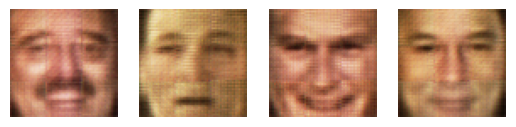

epoch_4


100%|██████████| 575/575 [00:25<00:00, 22.40it/s]


loss_epoch_4 = 0.0043170326170714


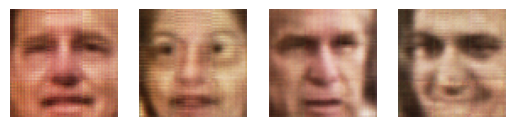

epoch_5


100%|██████████| 575/575 [00:25<00:00, 22.35it/s]


loss_epoch_5 = 0.0038633348144914794


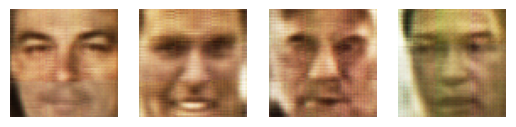

In [ ]:
loss = train(train_dataloader, autoencoder, 5, criterion, optimizer, val)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

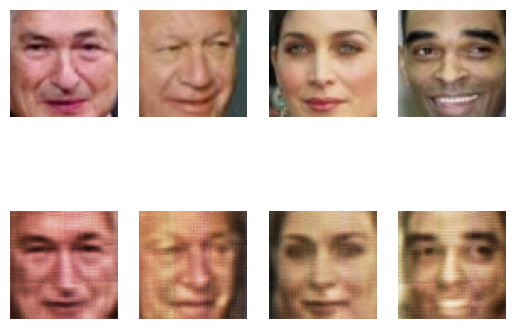

In [ ]:
def display2(data, model, count = 4):
  imgs = data[np.random.choice(len(data), count)]

  f, axarr = plt.subplots(2, count)
  for i in range(count):
      axarr[0][i].imshow(imgs[i].view(64,64,3))
      axarr[0][i].axis('off')

      img, _ = model(imgs[i].view(-1, 3, 64, 64))
      axarr[1][i].imshow(img.view(64,64,3).detach().numpy())
      axarr[1][i].axis('off')

  plt.show()


display2(val, autoencoder)

Not bad, right?

## 1.4. Sampling 

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:



In [ ]:
# сгенерируем 5 рандомных векторов размера latent_space
z = torch.Tensor(np.random.randn(5, latent_dims))
#z = torch.Tensor(np.random.randint(-25, 25, (5, latent_dims)))
output, _ = autoencoder.DECODER(z)

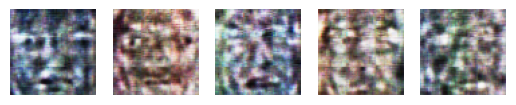

In [ ]:
def display3(model, data):
  f, axarr = plt.subplots(1, len(data))
  for i in range(len(data)):
      axarr[i].imshow(data[i].view(64,64,3).detach().numpy())
      axarr[i].axis('off')

  plt.show()

display3(autoencoder, output)

посмотрим как выглядят латентные векторы картинок из датасета

In [ ]:
z = train_dataset[:1000].view(-1, 3, 64, 64)
output = autoencoder.ENCODER(z)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, perplexity=50)
otp = tsne.fit_transform(output.detach().numpy())

In [ ]:
otp = otp.reshape(2, -1)

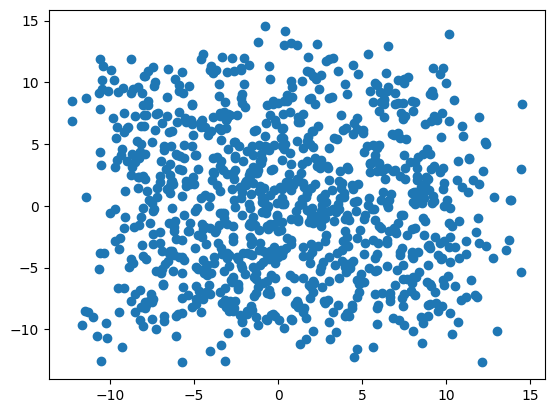

In [ ]:
plt.scatter(otp[0], otp[1])

## 1.5 Time to make fun! 

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
smile = attrs.Smiling[(attrs.Smiling > 0.7)][30:50].index
no_smile = attrs.Smiling[attrs.Smiling < -0.7][30:50].index

In [ ]:
mas_smile = []
mas_no_smile = []

for idx in smile:
  mas_smile.append(train_dataset[idx].view(-1, 3, 64, 64))
for idx in no_smile:
  mas_no_smile.append(train_dataset[idx].view(-1, 3, 64, 64))

mas_smile = torch.cat(mas_smile, dim=0)
mas_no_smile = torch.cat(mas_no_smile, dim=0)

latent_smile = autoencoder.ENCODER(mas_smile)
latent_no_smile = autoencoder.ENCODER(mas_no_smile)

In [ ]:
mean_smile = torch.mean(latent_smile)
mean_no_smile = torch.mean(latent_no_smile)

smiling = mean_smile - mean_no_smile

In [ ]:
x_old, _ = autoencoder.DECODER(latent_no_smile[0].view(1,-1))
latent_no_smile[0] += smiling
x, _ = autoencoder.DECODER(latent_no_smile[0].view(1,-1))

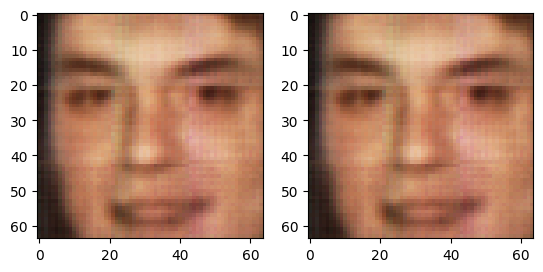

In [ ]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(x.view(64, 64, 3).detach().numpy())
axarr[1].imshow(x_old.view(64, 64, 3).detach().numpy())

# Часть 2: Variational Autoencoder

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
from torchvision import transforms
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 103784898.07it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 44617198.46it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27344077.39it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4564094.10it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение 

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dims, channels=1):
        super().__init__()
        self.training = True
        self.channels = channels
        self.encoder = nn.Sequential(
          nn.Conv2d(in_channels=self.channels, out_channels=8, kernel_size=3, stride=1),
          nn.BatchNorm2d(8),
          nn.PReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1),
          nn.BatchNorm2d(16),
          nn.PReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1),
          nn.BatchNorm2d(16),
          nn.PReLU()
        )


        self.fc1 = nn.Sequential(
          nn.Linear(16*3*3, latent_dims),
          nn.PReLU()
        )
        self.fc2 = nn.Sequential(
          nn.Linear(16*3*3, latent_dims),
          nn.PReLU()
        )

        self.decoder = nn.Sequential(
          nn.Linear(latent_dims, 16*3*3),
          nn.PReLU(),
          nn.Unflatten(1, (16,3,3)),
          nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=3, stride=2),
          nn.BatchNorm2d(16),
          nn.PReLU(),
          nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2),
          nn.BatchNorm2d(8),
          nn.PReLU(),
          nn.ConvTranspose2d(in_channels=8, out_channels=self.channels, kernel_size=2, stride=2, padding=1)
        )


    def encode(self, x):
        '''<реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu и logsigma>'''

        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.fc1(x)
        logsigma = self.fc2(x)

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
          std = torch.exp(0.5*logsigma)
          eps = torch.randn_like(std)
          z  = mu + (eps*std)
          return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        z = self.decoder(z)
        reconstruction = torch.sigmoid(z)
        return reconstruction.view(-1, 1, 28, 28)

    def forward(self, x):
        #x = torch.flatten(x, start_dim=1)
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5*(1+logsigma - mu**2 - torch.exp(logsigma)).sum()
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return log_likelihood(x, reconstruction) + KL_divergence(mu, logsigma)

In [ ]:
def display_new(data, model = None, count=4):
  model.training = False
  mas = np.random.choice(len(data), count)
  imgs = []
  for num in mas:
    imgs.append(data[num][0])

  f, axarr = plt.subplots(2, count)
  for i in range(count):
      mu, sigma, img = model(imgs[i].view(-1, 1, 28, 28))
      axarr[0][i].imshow(img.view(28,28).detach().numpy())
      axarr[0][i].axis('off')

      axarr[1][i].imshow(imgs[i].view(28,28))
      axarr[1][i].axis('off')

И обучим модель:

In [ ]:
criterion = loss_vae
latent_dims = 16
autoencoder = VAE(latent_dims, 1)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [ ]:
def train(model, data, optimizer, criterion, epochs, val):
  model.train()
  for epoch in range(epochs):
    loss_mas = []
    print(f'epoch_{epoch+1}')
    for batch, tagret in tqdm(data):
      optimizer.zero_grad()
      mu, logsigma, pred = model(batch.view(-1, 1, 28, 28))
      loss = criterion(batch.view(32, 1, 28, 28), mu, logsigma, pred.view(32, 1, 28, 28))
      loss_mas.append(loss.item())
      loss.backward()
      optimizer.step()
    print(f'loss = {torch.mean(torch.Tensor(loss_mas))}')
    '''model.eval()
    display_new(val, model)
    model.train()'''

train(autoencoder, train_loader, optimizer, criterion, 10, test_dataset)

epoch_1


100%|██████████| 1875/1875 [00:55<00:00, 33.56it/s]


loss = 4934.1630859375
epoch_2


100%|██████████| 1875/1875 [00:54<00:00, 34.66it/s]


loss = 3767.538818359375
epoch_3


100%|██████████| 1875/1875 [00:55<00:00, 33.54it/s]


loss = 3677.291259765625
epoch_4


100%|██████████| 1875/1875 [00:55<00:00, 33.50it/s]


loss = 3637.338623046875
epoch_5


100%|██████████| 1875/1875 [00:56<00:00, 33.42it/s]

loss = 3605.796630859375


Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

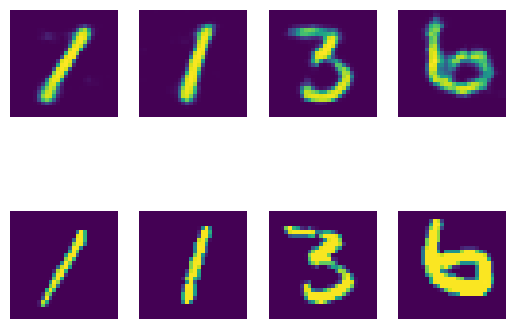

In [ ]:
display_new(test_dataset, autoencoder)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = torch.Tensor([np.random.normal(0, 1, latent_dims) for i in range(5)])

output = autoencoder.decode(z)

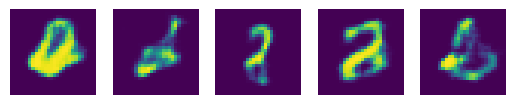

In [ ]:
def display_new2(model, data):
  f, axarr = plt.subplots(1, len(data))
  for i in range(len(data)):
      axarr[i].imshow(data[i].view(28,28).detach().numpy())
      axarr[i].axis('off')

  plt.show()

display_new2(autoencoder, output)

## 2.2. Latent Representation 

In [ ]:
z = []
trg = []
for elem in test_dataset:
  z.append(elem[0].view(-1,1,28,28))
  trg.append(elem[1])
z = torch.cat(z, dim=0)
mu, sigma = autoencoder.encode(z)
output = autoencoder.gaussian_sampler(mu, sigma)

In [ ]:
df_label = pd.DataFrame()
df_label['trg'] = trg

In [ ]:
df_img = pd.DataFrame(output.detach().numpy())

In [ ]:
tsne = TSNE(n_components=2, perplexity=50)
otp = tsne.fit_transform(df_img)

In [ ]:
otp = np.array(otp)
otp = otp.reshape(-1, 2)
otp = pd.DataFrame(otp)
df = pd.concat([otp, df_label], axis = 1)

In [ ]:
import seaborn as sns

<Axes: xlabel='0', ylabel='1'>

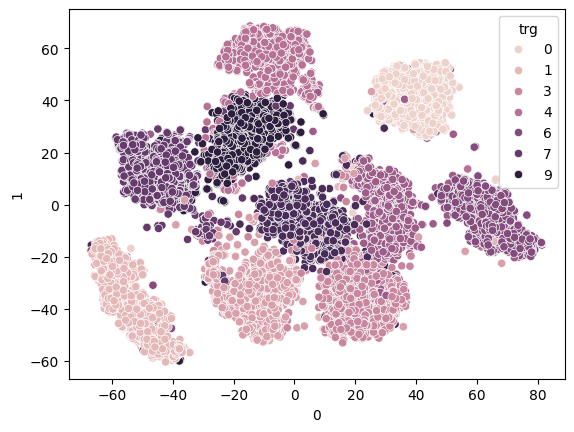

In [ ]:
sns.scatterplot(data=df, x=0, y=1, hue='trg')

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE 


### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



In [ ]:
class CVAE(nn.Module):
    def __init__(self, latent_dims, channels, encoded_numbers):
        '''<определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста",
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>'''
        super().__init__()
        self.training = True
        self.channels = channels
        self.encoded_numbers = encoded_numbers

        self.encoder = nn.Sequential(
          nn.Conv2d(in_channels=self.channels, out_channels=8, kernel_size=3, stride=1),
          nn.BatchNorm2d(8),
          nn.PReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1),
          nn.BatchNorm2d(16),
          nn.PReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1),
          nn.BatchNorm2d(16),
          nn.PReLU()
        )


        self.fc1 = nn.Sequential(
          nn.Linear(16*3*3, latent_dims),
          nn.PReLU()
        )
        self.fc2 = nn.Sequential(
          nn.Linear(16*3*3, latent_dims),
          nn.PReLU()
        )

        self.decoder = nn.Sequential(
          nn.Linear(latent_dims+10, 16*3*3),
          nn.PReLU(),
          nn.Unflatten(1, (16,3,3)),
          nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=3, stride=2),
          nn.BatchNorm2d(16),
          nn.PReLU(),
          nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2),
          nn.BatchNorm2d(8),
          nn.PReLU(),
          nn.ConvTranspose2d(in_channels=8, out_channels=self.channels, kernel_size=2, stride=2, padding=1)
        )

    def encode(self, x):
        '''<реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и класс картинки>'''

        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.fc1(x)
        logsigma = self.fc2(x)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            '''<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>'''
            std = torch.exp(0.5*logsigma)
            eps = torch.randn_like(std)
            z  = mu + (eps*std)
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, num_classes):
        '''<реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>'''
        ohe = self.onehot(num_classes)
        z = torch.cat([ohe, z], dim=1)
        z = self.decoder(z)
        reconstruction = torch.sigmoid(z)
        return reconstruction.view(-1, 1, 28, 28)

    def onehot(self, labels):
      ohe = [torch.Tensor(self.encoded_numbers[num]).view(1, -1) for num in labels]
      ohe = torch.cat(ohe, dim=0)
      return ohe

    def forward(self, x, labels):
        '''<используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>'''
        mu, logsigma = self.encode(x)

        z = self.gaussian_sampler(mu, logsigma)

        reconstruction = self.decode(z, labels)
        return mu, logsigma, reconstruction

In [ ]:
from sklearn.preprocessing import OneHotEncoder
numbers = np.array(range(10)).reshape(-1, 1)

encoder = OneHotEncoder(categories='auto', sparse=False)
encoded_numbers = encoder.fit_transform(numbers)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
criterion = loss_vae
latent_dims = 16
autoencoder = CVAE(latent_dims, 1, encoded_numbers)

optimizer = torch.optim.Adam(autoencoder.parameters())

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
def train(model, data, optimizer, criterion, epochs, val):
  model.train()
  for epoch in range(epochs):
    loss_mas = []
    print(f'epoch_{epoch+1}')
    for batch, target in tqdm(data):
      optimizer.zero_grad()
      mu, logsigma, pred = model(batch.view(-1, 1, 28, 28), target)
      loss = criterion(batch.view(32, 1, 28, 28), mu, logsigma, pred.view(32, 1, 28, 28))
      loss_mas.append(loss.item())
      loss.backward()
      optimizer.step()
    print(f'loss = {torch.mean(torch.Tensor(loss_mas))}')

train(autoencoder, train_loader, optimizer, criterion, 5, test_dataset)

epoch_1


100%|██████████| 1875/1875 [00:32<00:00, 56.89it/s]


loss = 4923.4951171875
epoch_2


100%|██████████| 1875/1875 [00:35<00:00, 53.27it/s]


loss = 3677.154296875
epoch_3


100%|██████████| 1875/1875 [00:32<00:00, 57.49it/s]


loss = 3584.40625
epoch_4


100%|██████████| 1875/1875 [00:32<00:00, 57.02it/s]


loss = 3535.445068359375
epoch_5


100%|██████████| 1875/1875 [00:32<00:00, 56.92it/s]

loss = 3505.362548828125


In [ ]:
t=0
for batch, target in tqdm(test_loader):
  t = target
  break
t = torch.Tensor([1])
for i in t:
  print(i)

torch.Tensor([test_dataset[0][1]])

  0%|          | 0/313 [00:00<?, ?it/s]

tensor(1.)


tensor([7.])

In [ ]:
otp = autoencoder(test_dataset[0][0].view(1,1,28,28), torch.Tensor([test_dataset[0][1]]))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
'''<тут нужно научиться сэмплировать из декодера цифры определенного класса>'''
z = torch.Tensor([np.random.normal(0, 1, latent_dims) for i in range(5)])

output = autoencoder.decode(z, )

<ipython-input-90-2992494d9d93>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  z = torch.Tensor([np.random.normal(0, 1, latent_dims) for i in range(5)])


TypeError: CVAE.decode() missing 1 required positional argument: 'num_classes'